# Generative Adverserial Network
## Ashutosh Raichurkar
## 001306059

Abstract : In this project , We introduce understanding of GANS for generating fake images. Its network architecture and problem associated with it are covered. The aim of this assignment was to understand the how we implents gans using 2 main blocks ie Decriminator and generator

# GANS
A generative adversarial network (GAN) is a class of machine learning frameworks invented by Ian Goodfellow and his colleagues in 2014. Two neural networks contest with each other in a game (in the sense of game theory, often but not always in the form of a zero-sum game).iven a training set, this technique learns to generate new data with the same statistics as the training set. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics. Though originally proposed as a form of generative model for unsupervised learning, GANs have also proven useful for semi-supervised learning, fully supervised learning, and reinforcement learning.

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://sigmoidal.io/wp-content/uploads/2017/09/generator_and_discriminator1.png")

## The MinMax Function

In [3]:

Image(url= "https://datascience.foundation/backend/web/uploads/blog/GAN%20Algorithm.png")

## Model 1

In [0]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [104]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [0]:
GENERATE_RES = 3 
GENERATE_SQUARE = 32 * GENERATE_RES 
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/projects'
EPOCHS = 17
BATCH_SIZE = 32
BUFFER_SIZE = 60000


In [107]:
training_binary_path = os.path.join(DATA_PATH,f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/projects/training_data_96_96.npy
Loading previous training pickle...


In [108]:
print(training_data)

[[[[-0.02745098  0.58431375 -0.27843136]
   [-0.02745098  0.58431375 -0.27843136]
   [-0.02745098  0.58431375 -0.27843136]
   ...
   [ 0.04313731  0.52156866 -0.41176468]
   [ 0.06666672  0.5294118  -0.41176468]
   [ 0.06666672  0.5294118  -0.41176468]]

  [[-0.00392157  0.6        -0.26274508]
   [-0.02745098  0.5764706  -0.2862745 ]
   [-0.03529412  0.56078434 -0.29411763]
   ...
   [ 0.05098045  0.5294118  -0.40392154]
   [ 0.05098045  0.5058824  -0.42745095]
   [ 0.04313731  0.5058824  -0.4352941 ]]

  [[-0.01960784  0.5764706  -0.27843136]
   [-0.03529412  0.5686275  -0.2862745 ]
   [-0.04313725  0.5529412  -0.30196077]
   ...
   [ 0.03529418  0.5137255  -0.41960782]
   [ 0.02745104  0.49803925 -0.42745095]
   [ 0.03529418  0.5058824  -0.42745095]]

  ...

  [[-0.9607843  -0.92941177 -0.92156863]
   [-0.9607843  -0.92941177 -0.92156863]
   [-0.9529412  -0.92941177 -0.92156863]
   ...
   [-0.7411765  -0.7254902  -0.6862745 ]
   [-0.7254902  -0.7254902  -0.64705884]
   [-0.7411765  

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [0]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

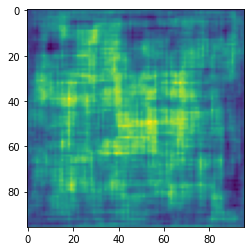

In [112]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [113]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5008074]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [0]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [121]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.6715224385261536,disc loss=1.0838977098464966, 0:00:15.73
Epoch 2, gen loss=0.6751478910446167,disc loss=1.0706942081451416, 0:00:15.74
Epoch 3, gen loss=0.6783835291862488,disc loss=1.0541541576385498, 0:00:15.68
Epoch 4, gen loss=0.6817211508750916,disc loss=1.0485910177230835, 0:00:15.66
Epoch 5, gen loss=0.6839825510978699,disc loss=1.0429160594940186, 0:00:15.69
Epoch 6, gen loss=0.6827782392501831,disc loss=1.0392732620239258, 0:00:15.66
Epoch 7, gen loss=0.6925750374794006,disc loss=1.0080574750900269, 0:00:15.72
Epoch 8, gen loss=0.6828005313873291,disc loss=1.0974018573760986, 0:00:15.66
Epoch 9, gen loss=0.6787500977516174,disc loss=1.0540790557861328, 0:00:15.68
Epoch 10, gen loss=0.6793431043624878,disc loss=1.0512664318084717, 0:00:15.71
Epoch 11, gen loss=0.68415766954422,disc loss=1.0462791919708252, 0:00:15.68
Epoch 12, gen loss=0.6884342432022095,disc loss=1.0218249559402466, 0:00:15.68
Epoch 13, gen loss=0.6836397647857666,disc loss=1.0364465713500

In [0]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

## Initial noise images
![title](Training_the_model.PNG)

## Output
![title](Model1.PNG)

## Model 2
Changing the epoch to 50.
Changing the activation of the genrator's activation function to 'Tanh'. 
Changing the Optimizer to RMSProp.

In [0]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("tanh"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("tanh"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [0]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output_model2')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.RMSprop(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1.5e-4,0.5)

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss,disc_loss

In [0]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [0]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

In [0]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)

In [154]:
train(train_dataset, 50)

Epoch 1, gen loss=0.6364523768424988,disc loss=1.2383452653884888, 0:00:22.18
Epoch 2, gen loss=0.6334753036499023,disc loss=1.205321192741394, 0:00:15.93
Epoch 3, gen loss=0.6270192861557007,disc loss=1.2372075319290161, 0:00:15.96
Epoch 4, gen loss=0.6267864108085632,disc loss=1.2273229360580444, 0:00:15.99
Epoch 5, gen loss=0.6318582892417908,disc loss=1.2109514474868774, 0:00:15.98
Epoch 6, gen loss=0.6369835734367371,disc loss=1.200624942779541, 0:00:16.00
Epoch 7, gen loss=0.6376403570175171,disc loss=1.184471607208252, 0:00:15.97
Epoch 8, gen loss=0.6391939520835876,disc loss=1.1759257316589355, 0:00:15.96
Epoch 9, gen loss=0.6448891162872314,disc loss=1.1610084772109985, 0:00:15.93
Epoch 10, gen loss=0.6482445597648621,disc loss=1.1442099809646606, 0:00:15.94
Epoch 11, gen loss=0.6534502506256104,disc loss=1.1296764612197876, 0:00:16.00
Epoch 12, gen loss=0.6596068739891052,disc loss=1.1100510358810425, 0:00:15.97
Epoch 13, gen loss=0.6608631610870361,disc loss=1.10659825801849

In [0]:
generator.save(os.path.join(DATA_PATH,"face_generator_model2.h5"))

## Model 2 Output
![title](model2.png)

The model 2 seems to provide a more better output than model1 after changing the epoches,activation function in the generator network and the optimer function

The number of epoches, hidden layers can imporve the accuracy of the model

**Conclusion:** Though the results generated are of very low resolution, this project implemented the understanding of GANS using custom dataset.

**Citations:**  
* https://www.youtube.com/watch?v=ydGC0IvlCNs&t=3s
* https://www.youtube.com/watch?time_continue=1878&v=rZufA635dq4&feature=emb_logo
* https://www.youtube.com/watch?v=5WoItGTWV54
* https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/

**Copyright 2020 Ashutosh Raichurkar**

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.